# Constructing our Minimum-Covariance Portfolios

We will be constructing our portfolios by selecting the assets which have the lowest correlations between each other. We will rebalance semi-annually based on these selections, and at each rebalance, ensure that our portfolio is split among the two geographies 50/50 

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [93]:
# Remove 1st line since they are pct changes, therefore have
# NaNs in the first row
rets = pd.read_csv("returns.csv")[1:]
rets.head()

,Date,EWJ,EWT,MCHI,EWY,EWZ,INDA,ACWV,IDV,EWC,...,EFNL,UAE,KWT,CNY=X,BRL=X,ZAR=X,RUB=X,EUR=X,JPY=X,MXN=X
1,2011-01-04,0.000804,-0.007407,NaN,0.002263,0.004396,NaN,NaN,-0.009259,-0.010412,...,NaN,NaN,NaN,-0.001760,0.019189,0.006326,0.0,0.000134,0.006743,-0.000384
2,2011-01-05,-0.007231,-0.016584,NaN,0.000376,-0.011616,NaN,NaN,-0.002596,0.002023,...,NaN,NaN,NaN,0.002584,0.012754,0.003853,0.0,0.002671,0.004506,-0.004249
3,2011-01-06,0.000000,-0.002108,NaN,-0.006960,-0.010049,NaN,NaN,-0.009891,-0.004847,...,NaN,NaN,NaN,-0.002956,0.004498,0.008670,0.0,0.012522,0.014030,0.003119
4,2011-01-07,0.003777,-0.015632,NaN,0.005493,-0.009119,NaN,NaN,-0.005258,0.000406,...,NaN,NaN,NaN,0.005929,0.006507,0.012983,0.0,0.013551,0.001334,0.000573
5,2011-01-10,0.000000,0.002146,NaN,-0.014883,-0.010071,NaN,NaN,0.000529,-0.003651,...,NaN,NaN,NaN,0.000151,-0.029895,-0.000295,0.0,0.006620,-0.003241,-0.001063


In [94]:
# Reindex to date
rets.index = pd.to_datetime(rets['Date'])
del rets['Date']
rets.head()

,EWJ,EWT,MCHI,EWY,EWZ,INDA,ACWV,IDV,EWC,EWU,...,EFNL,UAE,KWT,CNY=X,BRL=X,ZAR=X,RUB=X,EUR=X,JPY=X,MXN=X
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-04,0.000804,-0.007407,NaN,0.002263,0.004396,NaN,NaN,-0.009259,-0.010412,0.010462,...,NaN,NaN,NaN,-0.001760,0.019189,0.006326,0.0,0.000134,0.006743,-0.000384
2011-01-05,-0.007231,-0.016584,NaN,0.000376,-0.011616,NaN,NaN,-0.002596,0.002023,-0.002157,...,NaN,NaN,NaN,0.002584,0.012754,0.003853,0.0,0.002671,0.004506,-0.004249
2011-01-06,0.000000,-0.002108,NaN,-0.006960,-0.010049,NaN,NaN,-0.009891,-0.004847,-0.008647,...,NaN,NaN,NaN,-0.002956,0.004498,0.008670,0.0,0.012522,0.014030,0.003119
2011-01-07,0.003777,-0.015632,NaN,0.005493,-0.009119,NaN,NaN,-0.005258,0.000406,-0.003925,...,NaN,NaN,NaN,0.005929,0.006507,0.012983,0.0,0.013551,0.001334,0.000573
2011-01-10,0.000000,0.002146,NaN,-0.014883,-0.010071,NaN,NaN,0.000529,-0.003651,0.001751,...,NaN,NaN,NaN,0.000151,-0.029895,-0.000295,0.0,0.006620,-0.003241,-0.001063


In [96]:
rets.index

DatetimeIndex(['2011-01-04', '2011-01-05', '2011-01-06', '2011-01-07',
               '2011-01-10', '2011-01-11', '2011-01-12', '2011-01-13',
               '2011-01-14', '2011-01-17',
               ...
               '2021-06-21', '2021-06-22', '2021-06-23', '2021-06-24',
               '2021-06-25', '2021-06-28', '2021-06-29', '2021-06-30',
               '2021-07-01', '2021-07-02'],
              dtype='datetime64[ns]', name='Date', length=2739, freq=None)

In [211]:
# Create a list of semiannual dates to split on
dates_to_split = pd.date_range(rets.index[0], rets.index[-1], freq='6M')
dates_to_split

DatetimeIndex(['2011-01-31', '2011-07-31', '2012-01-31', '2012-07-31',
               '2013-01-31', '2013-07-31', '2014-01-31', '2014-07-31',
               '2015-01-31', '2015-07-31', '2016-01-31', '2016-07-31',
               '2017-01-31', '2017-07-31', '2018-01-31', '2018-07-31',
               '2019-01-31', '2019-07-31', '2020-01-31', '2020-07-31',
               '2021-01-31'],
              dtype='datetime64[ns]', freq='6M')

In [15]:
# Split on these dates
semiannual = {}

for i in range(len(dates_to_split)-1):
    #print(dates_to_split[i+1])
    semiannual[i] = rets[dates_to_split[i]:dates_to_split[i+1]]

In [16]:
# Sanity check
print(semiannual[0].index[0],semiannual[0].index[-1])

2011-01-31 00:00:00 2011-07-29 00:00:00


In [17]:
# Sanity check
print(semiannual[1].index[0],semiannual[1].index[-1])

2011-08-01 00:00:00 2012-01-31 00:00:00


In [18]:
# Sanity check
print(semiannual[19].index[0],semiannual[19].index[-1])

2020-07-31 00:00:00 2021-01-29 00:00:00


In [48]:
# For each group of 6mo, find the assets with lowest avg correlation
corrs = semiannual[10].corr().abs().mean(axis=1)
corrs

EWJ      0.521344
EWT      0.629399
MCHI     0.635343
EWY      0.675211
EWZ      0.533868
           ...   
ZAR=X    0.132302
RUB=X    0.095289
EUR=X    0.186922
JPY=X    0.081194
MXN=X    0.569602
Length: 63, dtype: float64

In [212]:
# Sort those values to see which ones have lowest correlation
corrs.sort_values(axis=0)[:15]

BRL=X    0.083565
EUR=X    0.086445
JPY=X    0.092729
RUB=X    0.095436
ZAR=X    0.114694
MXN=X    0.130118
CNY=X    0.179067
QAT      0.549102
UAE      0.603764
KSA      0.643917
TUR      0.652486
ECH      0.656713
ERUS     0.659307
ICOL     0.677951
IHAK     0.689661
dtype: float64

In [59]:
# Loop through each semiannual period, save the 15 assets with the
# lowest average correlation
top15 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    top15[i] = corrs.sort_values(axis=0)[:15]
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [214]:
# Sanity check
top15[1]

JPY=X    0.062533
ZAR=X    0.082907
BRL=X    0.087842
EUR=X    0.096772
RUB=X    0.109081
CNY=X    0.151405
EPU      0.279423
TUR      0.456374
EPHE     0.472195
ECH      0.472588
EWJ      0.490160
EIRL     0.506789
THD      0.512818
EIDO     0.535419
EWZ      0.569169
dtype: float64

In [215]:
# We only need the index
top15[1].index

Index(['JPY=X', 'ZAR=X', 'BRL=X', 'EUR=X', 'RUB=X', 'CNY=X', 'EPU', 'TUR',
       'EPHE', 'ECH', 'EWJ', 'EIRL', 'THD', 'EIDO', 'EWZ'],
      dtype='object')

In [216]:
# Let's create a one-period example before looping through them all, start
# with 100k capital
capital = 100000

In [219]:
# Use previous period's lowest corrs to construct portfolio
# for current period
returns = semiannual[1][top15[1].index]
returns

,JPY=X,ZAR=X,BRL=X,EUR=X,RUB=X,CNY=X,EPU,TUR,EPHE,ECH,EWJ,EIRL,THD,EIDO,EWZ
Date,,,,,,,,,,,,,,,
2011-08-01,-0.006651,-0.007357,-0.010430,-0.002150,0.002785,-0.002219,0.005180,-0.006188,0.009129,0.020165,-0.009287,-0.036894,0.002510,0.012581,-0.006637
2011-08-02,0.003199,0.008252,0.007307,0.007182,0.004507,-0.000482,-0.027197,-0.030212,-0.015625,-0.027369,-0.008547,-0.013722,-0.021459,-0.013096,-0.028211
2011-08-03,-0.001614,0.010074,0.003531,0.006275,0.003179,0.000560,-0.012655,0.021165,0.000835,-0.013722,0.001947,-0.015072,0.003289,0.004423,-0.016998
2011-08-04,-0.002884,-0.010607,-0.000192,-0.012613,-0.000783,-0.000342,-0.054844,-0.081509,-0.035476,-0.054244,-0.060783,-0.057681,-0.038069,-0.051152,-0.067029
2011-08-05,0.028245,0.032729,0.008829,0.020382,0.014975,0.000124,-0.005046,-0.038793,0.000000,-0.021043,0.009161,0.000000,-0.009657,-0.035345,0.005623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-01-25,0.008922,0.002244,0.003653,-0.001042,-0.002271,0.001267,0.022340,0.020039,-0.001661,-0.003078,0.012608,0.004049,0.006905,-0.006278,0.019697
2012-01-26,0.001068,-0.009787,0.000910,-0.005086,-0.010080,-0.001345,0.015814,0.019918,-0.011231,0.004245,-0.002126,0.015553,0.001210,-0.003716,-0.013908
2012-01-27,-0.003986,-0.006987,0.052557,0.001180,-0.004352,0.003247,0.001981,0.027822,0.020194,0.005573,0.005478,-0.011912,0.022160,0.000373,0.002351


In [220]:
# Save the sum of the dollar returns, add to capital
capital += returns.cumsum().iloc[-1,:].sum()
capital

100000.13189404825

<AxesSubplot:xlabel='Date'>

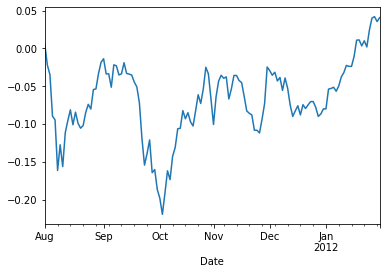

In [221]:
# Sanity check to make sure calculation is correct
returns['EPU'].cumsum().plot()

In [222]:
# Reallocate capital and rebalance
position_size = capital / 15
position_size

6666.675459603216

In [223]:
# Use new allocations to calculate next period
returns2 = semiannual[2][top15[2].index] * position_size
returns2

,CNY=X,JPY=X,RUB=X,ZAR=X,BRL=X,EUR=X,KXI,ACWV,MCHI,MXN=X,EIRL,EPHE,EIDO,TUR,EIS
Date,,,,,,,,,,,,,,,
2012-01-31,-10.963540,-32.320326,52.335227,73.008508,31.837403,35.222166,-10.139430,3.163310,45.265314,44.076598,-57.339525,103.947321,-42.864403,-93.579536,41.129237
2012-02-01,-5.279615,-7.857527,-66.293333,-30.999079,-5.726400,31.533349,66.006688,61.655286,120.492920,-86.143584,181.222526,168.741578,129.425371,356.798080,115.198963
2012-02-02,-1.902168,-7.080119,17.083686,-111.057070,-50.053558,-47.077347,-7.541488,6.265672,37.095968,-48.656575,0.000000,113.314597,62.235581,36.703418,-40.182701
2012-02-03,-2.748360,-0.787516,7.391385,-21.230342,-52.357098,16.682054,57.883554,31.298946,107.158683,-69.141456,0.000000,34.487378,64.126364,54.753681,106.578604
2012-02-06,0.422999,32.467007,3.271597,-84.494368,-10.864729,5.254868,-14.970080,-49.844303,-93.361119,2.634466,153.904107,-15.835334,-141.688229,42.787845,-101.284272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-07-25,1.565903,-17.366676,61.154097,48.970966,29.791174,34.755946,0.000000,30.309959,-21.877515,-53.249760,95.980930,19.629519,32.480757,92.022141,127.444686
2012-07-26,1.043690,-0.341412,-53.550034,-88.068598,-41.717646,-43.420634,160.415404,82.975141,127.706444,-96.621327,130.100704,92.966483,123.905887,267.445040,51.746511
2012-07-27,-4.695871,18.864004,-75.911966,-122.884006,-41.324401,-76.079579,99.055648,73.014550,182.085409,-85.208732,204.950000,82.036542,185.111972,155.836266,147.625355


In [224]:
# Concatenate to get continuous stream
pd.concat([returns, returns2])

,JPY=X,ZAR=X,BRL=X,EUR=X,RUB=X,CNY=X,EPU,TUR,EPHE,ECH,EWJ,EIRL,THD,EIDO,EWZ,KXI,ACWV,MCHI,MXN=X,EIS
Date,,,,,,,,,,,,,,,,,,,,
2011-08-01,-0.006651,-0.007357,-0.010430,-0.002150,0.002785,-0.002219,0.005180,-0.006188,0.009129,0.020165,-0.009287,-0.036894,0.002510,0.012581,-0.006637,NaN,NaN,NaN,NaN,NaN
2011-08-02,0.003199,0.008252,0.007307,0.007182,0.004507,-0.000482,-0.027197,-0.030212,-0.015625,-0.027369,-0.008547,-0.013722,-0.021459,-0.013096,-0.028211,NaN,NaN,NaN,NaN,NaN
2011-08-03,-0.001614,0.010074,0.003531,0.006275,0.003179,0.000560,-0.012655,0.021165,0.000835,-0.013722,0.001947,-0.015072,0.003289,0.004423,-0.016998,NaN,NaN,NaN,NaN,NaN
2011-08-04,-0.002884,-0.010607,-0.000192,-0.012613,-0.000783,-0.000342,-0.054844,-0.081509,-0.035476,-0.054244,-0.060783,-0.057681,-0.038069,-0.051152,-0.067029,NaN,NaN,NaN,NaN,NaN
2011-08-05,0.028245,0.032729,0.008829,0.020382,0.014975,0.000124,-0.005046,-0.038793,0.000000,-0.021043,0.009161,0.000000,-0.009657,-0.035345,0.005623,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-07-25,-17.366676,48.970966,29.791174,34.755946,61.154097,1.565903,NaN,92.022141,19.629519,NaN,NaN,95.980930,NaN,32.480757,NaN,0.000000,30.309959,-21.877515,-53.249760,127.444686
2012-07-26,-0.341412,-88.068598,-41.717646,-43.420634,-53.550034,1.043690,NaN,267.445040,92.966483,NaN,NaN,130.100704,NaN,123.905887,NaN,160.415404,82.975141,127.706444,-96.621327,51.746511
2012-07-27,18.864004,-122.884006,-41.324401,-76.079579,-75.911966,-4.695871,NaN,155.836266,82.036542,NaN,NaN,204.950000,NaN,185.111972,NaN,99.055648,73.014550,182.085409,-85.208732,147.625355


In [225]:
# Generalize to all time periods

capital = 100000
dollar_full_portfolio = pd.DataFrame()
pct_full_portfolio = pd.DataFrame()
PnL = {}

for i in range(1,len(semiannual.keys())):
    position_size = capital / 15
    returns = semiannual[i][top15[i].index]
    
    
    # Remove an outlier
    returns[returns.values > 100] = 0
    
    pct_full_portfolio = pd.concat([pct_full_portfolio, returns])
    dollar_full_portfolio = pd.concat([dollar_full_portfolio, returns*position_size])
    
    capital += sum(returns.iloc[-1,:])
    
    PnL[i] = returns.sum(axis=1)

/Users/lucaskrenn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lucaskrenn/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


In [227]:
dollar_full_portfolio = dollar_full_portfolio.fillna(0)

<AxesSubplot:xlabel='Date'>

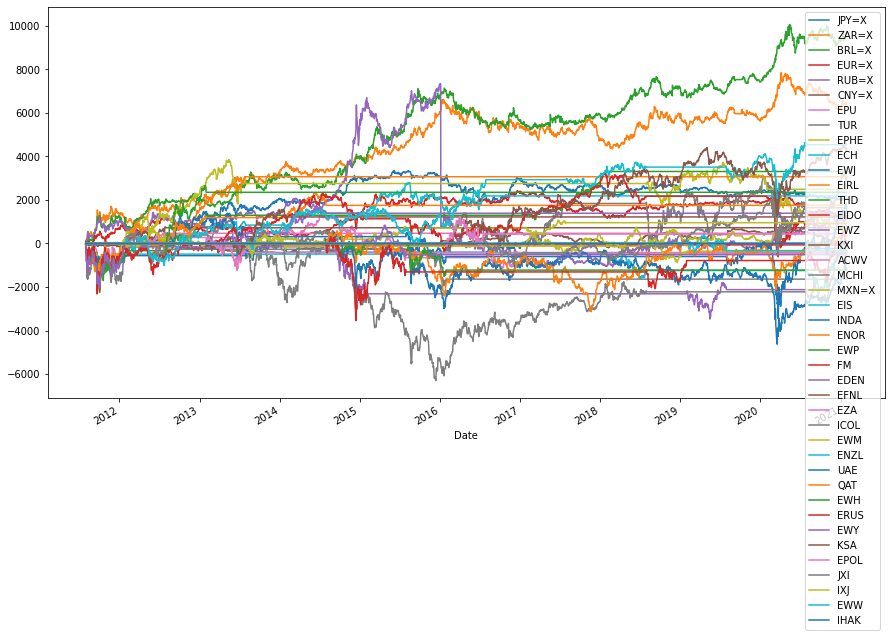

In [228]:
dollar_full_portfolio.cumsum().plot(figsize = (15,8))

<AxesSubplot:xlabel='None,Date'>

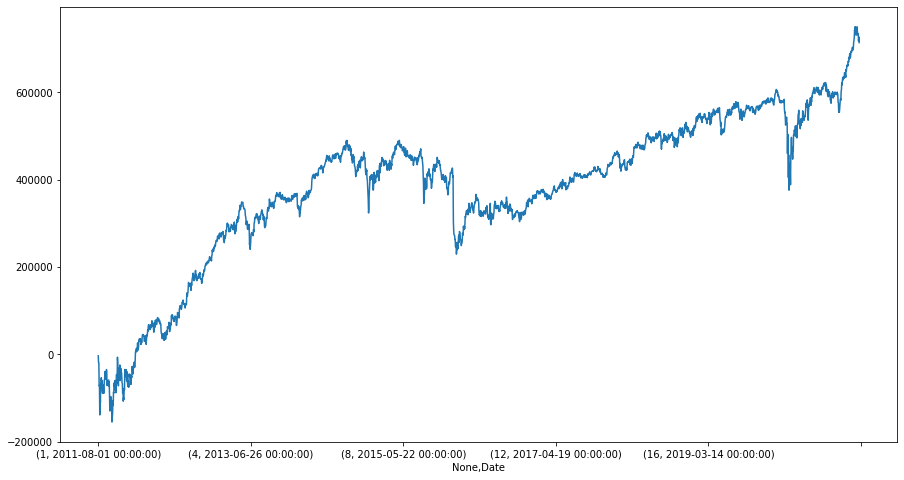

In [233]:
# PnL of whole portfolio 
(pd.concat(PnL)* 100000).cumsum().plot(figsize=(15,8))